<a href="https://colab.research.google.com/github/chinmay5/NLP-Praktikum/blob/sentence_embedding/SiameseMitLASER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


# This is an attempt to include the LASER multi lingual embedding


In [1]:
!git clone https://github.com/ceshine/LASER.git

Cloning into 'LASER'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 591 (delta 11), reused 24 (delta 11), pack-reused 560
Receiving objects: 100% (591/591), 2.60 MiB | 2.82 MiB/s, done.
Resolving deltas: 100% (175/175), done.


In [0]:
#!rm -rf \"

In [3]:
%env LASER=/content/LASER
!echo $LASER


env: LASER=/content/LASER
/content/LASER


In [4]:
!pwd


/content


In [5]:
%cd LASER

/content/LASER


In [6]:
! pwd

/content/LASER


In [7]:
!bash install_models.sh

 - creating directory /content/LASER/models
 - bilstm.93langs.2018-12-26.pt
 - 93langs.fcodes
 - 93langs.fvocab


In [8]:
!bash install_external_tools.sh

Installing external tools
 - creating directory /content/LASER/tools-external/moses-tokenizer/tokenizer
 - download tokenizer/tokenizer.perl
 - download tokenizer/detokenizer.perl
 - download tokenizer/normalize-punctuation.perl
 - download tokenizer/remove-non-printing-char.perl
 - download tokenizer/deescape-special-chars.perl
 - download tokenizer/lowercase.perl
 - download tokenizer/basic-protected-patterns
 - creating directory /content/LASER/tools-external/moses-tokenizer/share/nonbreaking_prefixes
 - download share/nonbreaking_prefixes/nonbreaking_prefix.ca
 - download share/nonbreaking_prefixes/nonbreaking_prefix.cs
 - download share/nonbreaking_prefixes/nonbreaking_prefix.de
 - download share/nonbreaking_prefixes/nonbreaking_prefix.el
 - download share/nonbreaking_prefixes/nonbreaking_prefix.en
 - download share/nonbreaking_prefixes/nonbreaking_prefix.es
 - download share/nonbreaking_prefixes/nonbreaking_prefix.fi
 - download share/nonbreaking_prefixes/nonbreaking_prefix.fr
 -

In [16]:
%cd /content/LASER
%cd tools-external/fastBPE/
! g++ -std=c++11 -pthread -O3 fastBPE/main.cc -IfastBPE -o fast

/content/LASER
/content/LASER/tools-external/fastBPE


In [10]:
%cd ../../tasks/similarity/
! ls

/content/LASER/tasks/similarity
README.md  wmt.sh


In [11]:
! apt install libopenblas-base libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libopenblas-base is already the newest version (0.2.20+ds-4).
libopenblas-base set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 16 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 2s (112 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 130942 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb .

In [12]:
! pip install faiss

     |████████████████████████████████| 4.7MB 2.7MB/s 


In [13]:
% cd /content/LASER/tasks/similarity
! bash wmt.sh

[Errno 2] No such file or directory: './tasks/similarity'
/content/LASER/tasks/similarity
 - Download WMT data
LASER: similarity search

Processing:
 - loading encoder /content/LASER/models/bilstm.93langs.2018-12-26.pt
 - transfer encoder to GPU
 - creating directory embed
 - Tokenizer: newstest2012.cs in language cs  
 - fast BPE: processing newstest2012.tok.cs
 - Encoder: newstest2012.bpe.cs to newstest2012.enc.cs
 - Encoder: 3003 sentences in 5s
 - embedding: ./embed/newstest2012.enc.cs 3003 examples of dim 1024
 - creating FAISS index
 - Tokenizer: newstest2012.de in language de  
 - fast BPE: processing newstest2012.tok.de
 - Encoder: newstest2012.bpe.de to newstest2012.enc.de
 - Encoder: 3003 sentences in 5s
 - embedding: ./embed/newstest2012.enc.de 3003 examples of dim 1024
 - creating FAISS index
 - Tokenizer: newstest2012.en in language en  
 - fast BPE: processing newstest2012.tok.en
 - Encoder: newstest2012.bpe.en to newstest2012.enc.en
 - Encoder: 3003 sentences in 4s
 - em

In [0]:
# sample feasibility check
# % cd ../../source/

import os
import sys
LASER = os.environ['LASER']
# now include the extra files in the source
sys.path.append(LASER + '/source')
sys.path.append(LASER + '/source/lib')

In [0]:
from embed import SentenceEncoder, EncodeLoad, EncodeFile
from text_processing import Token, BPEfastApply
from indexing import IndexCreate, IndexSearchMultiple, IndexPrintConfusionMatrix

## These are the steps to replicate results of the LSTM file

In [0]:
MODEL_PATH = '/content/LASER/models/'
sentence_encoder = SentenceEncoder(
    str(MODEL_PATH + "bilstm.93langs.2018-12-26.pt"),
    max_sentences=None,
    max_tokens=10000,
    cpu=False)
sentence_encoder.use_cuda=True #just a guess not sure if this would actually help

In [0]:
# Dictionary for label to index, this has been pre-generated
encoding_to_labels = {
   0:	"Amazon Instant Videos",
   1 :"Android Apps",
   2 : "Automotive",
   3 :"Baby",
   4 :"Beauty",
   5 :"CDs and Vinyl",
   6 :"Cell Phones and Accessories",
   7 :"Clothing, Shoes, Jewelry",
   8 :"Digital Music",
   9 :"Electronics",
  10 :"Grocery and Gourmet",
  11 :"Health and Personal Care",
  12 :"Home and Kitchen",
  13 :"Kindle",
  14 :"Movies and TV",
  15 :"Musical Instruments",
  16 :"Office Products",
  17 :"Patio Garden",
  18 :"Pet Supplies",
  19 :"Sports, Outdoors",
  20 :"Tool and Home Improvement",
  21 :"Toys_and_Games",
  22 :"Video Games"
}

In [0]:
def get_lebel_from_code(code):
  if code not in encoding_to_labels.keys():
    raise KeyError("Invalid Code")
  return encoding_to_labels[code]

def get_all_labels():
  return list(encoding_to_labels.values())

# This is the code section for trying Triplet Generation


In [0]:
from torch.utils.data import Dataset
import numpy as np

class TripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, select_column, training_mode=True):
         
        
        self.dataset = dataset
        self.train = training_mode
        self.select_column = select_column
        if self.train:
            self.train_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
            self.dataset = self.dataset.drop('labels_encoded', axis=1)
            self.train_data = self.dataset
            self.labels_set = set(self.train_labels.to_numpy())
            self.label_to_indices = {label: np.where(self.train_labels.to_numpy() == label)[0]
                                     for label in self.labels_set} # redundent in our case if we decide to use numeric labels based on certain sklearn packages

        else:
            self.test_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
            self.dataset = self.dataset.drop('labels_encoded', axis=1)
            self.test_data = self.dataset
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.to_numpy())
            self.label_to_indices = {label: np.where(self.test_labels.to_numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(42)
            
            #print("Length of the dataset is {}".format(len(self.test_data)))
            
            triplets = []
            for i in range(len(self.test_data)):
                  triplets.append([i,
                           random_state.choice(self.label_to_indices[self.test_labels.iloc[i]]),
                           random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels.iloc[i]]))
                                                 )
                                             ])
                         ]) 
                         
            self.test_triplets = triplets
           
    def __getitem__(self, index):
        if self.train:
            #print(type(self.train_data))
            img1, label1 = self.train_data.iloc[index], self.train_labels.iloc[index]
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            img2 = self.train_data.iloc[positive_index]
            img3 = self.train_data.iloc[negative_index]
        else:
            img1 = self.test_data.iloc[self.test_triplets[index][0]]
            img2 = self.test_data.iloc[self.test_triplets[index][1]]
            img3 = self.test_data.iloc[self.test_triplets[index][2]]

        img1 = img1[self.select_column]
        img2 = img2[self.select_column]
        img3 = img3[self.select_column]
        
        #print("Computation of the entities are completed")

        return (img1, img2, img3)

    def __len__(self):
        return len(self.dataset)

## Load the entire dataset in this section

In [0]:
import pandas as pd
%cd /content/
input_data = pd.read_csv('actual_dataset.csv')

/content


FileNotFoundError: ignored

In [0]:
input_data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime',
       'Product_Category'],
      dtype='object')

In [0]:
input_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Product_Category
0,A1VXOAVRGKGEAK,439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5,Magnetic board,1390953600,"01 29, 2014",Toys_and_Games
1,A8R62G708TSCM,439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4,it works pretty good for moving to different a...,1395964800,"03 28, 2014",Toys_and_Games
2,A21KH420DK0ICA,439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5,love this!,1359331200,"01 28, 2013",Toys_and_Games
3,AR29QK6HPFYZ4,439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5,Daughters love it,1391817600,"02 8, 2014",Toys_and_Games
4,ACCH8EOML6FN5,439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014",Toys_and_Games


### We would use review.text as the input and use it to predict review.primaryCategories

In [0]:
input_data.Product_Category.describe()

count       2300
unique        23
top       Beauty
freq         100
Name: Product_Category, dtype: object

In [0]:
input_data = input_data.rename(columns={'Product_Category':'label'})
input_data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,label
0,A1VXOAVRGKGEAK,439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5,Magnetic board,1390953600,"01 29, 2014",Toys_and_Games
1,A8R62G708TSCM,439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4,it works pretty good for moving to different a...,1395964800,"03 28, 2014",Toys_and_Games
2,A21KH420DK0ICA,439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5,love this!,1359331200,"01 28, 2013",Toys_and_Games
3,AR29QK6HPFYZ4,439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5,Daughters love it,1391817600,"02 8, 2014",Toys_and_Games
4,ACCH8EOML6FN5,439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014",Toys_and_Games


In [0]:
LASER = os.environ['LASER']
FASTBPE = LASER + '/tools-external/fastBPE/fast'
MOSES_BDIR = LASER + '/tools-external/moses-tokenizer/tokenizer/'
MOSES_TOKENIZER = MOSES_BDIR + 'tokenizer.perl -q -no-escape -threads 20 -l '
MOSES_LC = MOSES_BDIR + 'lowercase.perl'
NORM_PUNC = MOSES_BDIR + 'normalize-punctuation.perl -l '
DESCAPE = MOSES_BDIR + 'deescape-special-chars.perl'
REM_NON_PRINT_CHAR = MOSES_BDIR + 'remove-non-printing-char.perl'
MECAB = LASER + '/tools-external/mecab'

In [0]:
from subprocess import check_output
def sample_token(string_val, lang='en'):
    tok = check_output(
                REM_NON_PRINT_CHAR
                + '|' + NORM_PUNC + lang
                + '|' + DESCAPE
                + '|' + MOSES_TOKENIZER + lang
                + ('| python3 -m jieba -d ' if lang == 'zh' else '')
                + ('|' + MECAB + '/bin/mecab -O wakati -b 50000 ' if lang == 'ja' else ''),
                input=string_val,
                encoding='UTF-8',
                shell=True)
    return tok.strip()

### Clean the data as that might cause problems later

In [0]:
index = input_data.reviewText.isnull()==True
samp = index[index==True]
input_data = input_data.drop(samp.index)

In [0]:
input_data.reviewText.isnull().sum() #Value should be always zero

0

In [0]:
"""
  Do the above mentioned operation on all the entries in the column. So,
  
"""
input_data['tokenized_review'] = input_data.reviewText.apply(sample_token)

In [0]:
bpe_codes = './LASER/models/93langs.fcodes'
bpe_vocab = bpe_codes.replace('fcodes', 'fvocab')


def apply_bpe(sentence):
  sentence = sentence.replace('"','\\"')
  bpe = check_output(
      'echo -n "'+sentence +'" | '+ FASTBPE + ' applybpe_stream '+  bpe_codes +' '+bpe_vocab,
      encoding='UTF-8',
      shell=True)
  return bpe.strip()


#input_data['tokenized_review_bpe'] = input_data.reviewText.apply(bpe_sentences)


In [0]:
tok_sentence = '"love the magnet easel ... " slow motion me "great for moving to different areas ... wish it had some sort of non skid pad on bottom though ...'
apply_bpe(tok_sentence)

'"@@ love the magn@@ et ea@@ sel ... " slo@@ w motion me "@@ great for mo@@ ving to different areas ... wish it had some sort of non sk@@ id pad on bot@@ tom though ...'

In [0]:
input_data['tokenized_review_bpe'] = input_data.tokenized_review.apply(apply_bpe)


In [0]:
"""
  Let's encode the values in here so that we can use them as label encoder later
"""
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

input_data['labels_encoded'] = le.fit_transform(input_data['label'])

In [0]:

input_data.to_csv('./preprocessed_output.csv')

NameError: ignored

# Reading preprocessed output uptil BPE and then converting it into sentence embeddings

In [0]:
# Trying to apply the sentence encoding so that we can store the entire thing
%cd /content/
import pandas as pd
input_data = pd.read_csv('./preprocessed_output.csv')

/content


In [0]:
# Directly copy pasted from stackoverflow 
# https://stackoverflow.com/questions/35092720/verbosity-pandas-apply

In [0]:
# Because of the nature in which LASER tends to perform encoding we have to do this extra tweek
def to_list(element):
  return [element]

In [0]:
input_data['tokenized_review_bpe_list'] = input_data.tokenized_review_bpe.apply(to_list)


In [0]:
from pandas import Series

def progress_coroutine(print_on = 10):
    print ("Starting progress monitor")

    iterations = 0
    while True:
        yield
        iterations += 1
        if (iterations % print_on == 0):
            print ("{} iterations done".format(iterations))

def percentage_coroutine(to_process, print_on_percent = 0.10):
    print ("Starting progress percentage monitor")

    processed = 0
    count = 0
    print_count = to_process*print_on_percent
    while True:
        yield
        processed += 1
        count += 1
        if (count >= print_count):
            count = 0
            pct = (float(processed)/float(to_process))*100

            print ("{}% finished".format(pct))

def trace_progress(func, progress = None):
    def callf(*args, **kwargs):
        if (progress is not None):
            progress.send(None)

        return func(*args, **kwargs)

    return callf

def my_func(i):
    return i ** 2

data_series = input_data.tokenized_review_bpe_list
#co1 = progress_coroutine()
co2 = percentage_coroutine(len(data_series))
input_data['sentence_embedding'] = data_series.apply(trace_progress(sentence_encoder.encode_sentences, progress = co2))

Starting progress percentage monitor
10.004349717268378% finished
20.008699434536755% finished
30.01304915180513% finished
40.01739886907351% finished
50.021748586341886% finished
60.02609830361026% finished
70.03044802087864% finished
80.03479773814702% finished
90.0391474554154% finished


In [0]:
"""
  Please let this be here for debugging purpose. The output shape should be (1,1024) ideally

"""
# string_input = 'I like the item pri@@ cing . M@@ y grand@@ dau@@ ghter wanted to mark on it but I wanted it just for the let@@ ters .'
# sentence = (to_list(string_input))
# print(sentence_encoder.encode_sentences(sentence).shape)

(1, 1024)


In [0]:
# The value should be True
len(input_data.sentence_embedding.iloc[0]) == 1 

True

In [0]:
input_data = input_data[['sentence_embedding','labels_encoded']]

In [0]:
input_data.to_pickle('./preprocessed_sentence_encoded.pkl')

## The code here basically reads the data from Drive and performs the same set of operations

## If you already have the preprocessed data, use it here

In [0]:
# Reading the file from gdrive which is faster than downloading it
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
%cd /content/
input_data = pd.read_csv('/gdrive/My Drive/d_training_concatenated_230k.csv', index_col=0)

/content


In [0]:
input_data.columns

Index(['Unnamed: 0.1', 'label', 'reviewText', 'tokenized_review',
       'tokenized_review_bpe'],
      dtype='object')

In [0]:
input_data.head()
#input_data = input_data.drop('Unnamed:0', axis=1)
df = input_data
df = df[pd.notnull(df['tokenized_review_bpe'])]

In [0]:
df.tokenized_review_bpe.isnull().sum()

0

In [0]:
input_data = df

##  Same set of preprocessing equations that we used for the actual index file

In [0]:
# Because of the nature in which LASER tends to perform encoding we have to do this extra tweek
def to_list(element):
  return [element]

In [0]:
input_data['tokenized_review_bpe_list'] = input_data.tokenized_review_bpe.apply(to_list)


In [0]:
from pandas import Series

def progress_coroutine(print_on = 10):
    print ("Starting progress monitor")

    iterations = 0
    while True:
        yield
        iterations += 1
        if (iterations % print_on == 0):
            print ("{} iterations done".format(iterations))

def percentage_coroutine(to_process, print_on_percent = 0.10):
    print ("Starting progress percentage monitor")

    processed = 0
    count = 0
    print_count = to_process*print_on_percent
    while True:
        yield
        processed += 1
        count += 1
        if (count >= print_count):
            count = 0
            pct = (float(processed)/float(to_process))*100

            print ("{}% finished".format(pct))

def trace_progress(func, progress = None):
    def callf(*args, **kwargs):
        if (progress is not None):
            progress.send(None)

        return func(*args, **kwargs)

    return callf

def my_func(i):
    return i ** 2

data_series = input_data.tokenized_review_bpe_list
co1 = progress_coroutine()
co2 = percentage_coroutine(len(data_series))
input_data['sentence_embedding'] = data_series.apply(trace_progress(sentence_encoder.encode_sentences, progress = co1))

In [0]:
# The value should be True
len(input_data.sentence_embedding.iloc[0]) == 1 

NameError: ignored

In [0]:
# Drop irrelevant columns now
input_data = input_data[['sentence_embedding','labels_encoded']]

In [0]:
data_series.to_pickle('/gdrive/My Drive/d_training_concatenated_183k_embedded.pkl')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


# If you have sentence embedded dataframe present, use those here directly

In [22]:
# Reading the file from gdrive which is faster than downloading it
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
#input_data.to_csv('/gdrive/My Drive/d_training_concatenated_183k_encoded.pkl')
input_data = pd.read_pickle('/gdrive/My Drive/d_training_final.pkl')

In [24]:
len(input_data.sentence_embedding)

193940

In [0]:
"""
  Leaving this line here because used it to generate the csv file.
  Should be refactored in the next iteration
"""
# temp_input_data = input_data[:183943]
# len(temp_input_data)
# temp_input_data.to_csv('/gdrive/My Drive/d_training_concatenated_183k.csv')

'\n  Leaving this line here because used it to generate the csv file.\n  Should be refactored in the next iteration\n'

In [0]:
"""
  Let's encode the values in here so that we can use them as label encoder later
"""
# import labelencoder
# from sklearn.preprocessing import LabelEncoder
# # instantiate labelencoder object
# le = LabelEncoder()

# input_data['labels_encoded'] = le.fit_transform(input_data['label'])

"""
  We are leaving this part here again for completeness since we have a preprocessed dataframe which 
  has most of the things in place
"""

input_data.head()

,sentence_embedding,labels_encoded
0,"[[0.017418101, 0.003224724, 0.00979801, 0.0071...",20
1,"[[0.0093318345, -3.4339969e-06, 0.005169349, 0...",17
2,"[[0.018201692, -7.0058045e-06, 0.0027392416, 0...",16
3,"[[0.015383401, -2.7567687e-06, -0.0008938909, ...",15
4,"[[0.0031439448, -4.9704126e-05, 0.06903063, 0....",20


In [0]:
# The value should be True
#len(input_data.sentence_embedding.iloc[0]) == 1 
input_data.sentence_embedding.iloc[0].shape

(1, 1024)

##Quickly check if both train and validate dataloaders work

In [0]:
input_data.head()

,sentence_embedding,labels_encoded
0,"[[0.017418101, 0.003224724, 0.00979801, 0.0071...",20
1,"[[0.0093318345, -3.4339969e-06, 0.005169349, 0...",17
2,"[[0.018201692, -7.0058045e-06, 0.0027392416, 0...",16
3,"[[0.015383401, -2.7567687e-06, -0.0008938909, ...",15
4,"[[0.0031439448, -4.9704126e-05, 0.06903063, 0....",20


In [0]:
from torch.utils.data import DataLoader
batch_size = 1000
siamese_train_dataset = TripletDataset(training_mode=True,dataset=input_data,select_column='sentence_embedding')
loader = DataLoader(siamese_train_dataset, batch_size=batch_size,shuffle=True)

NameError: ignored

In [0]:
for index, (img1,img2,img3) in enumerate(loader):
  print (img1.shape)
  print(img2.shape)
  print(img3.shape)
  break
  

torch.Size([1000, 1, 1024])
torch.Size([1000, 1, 1024])
torch.Size([1000, 1, 1024])


In [0]:
siamese_val_dataset = TripletDataset(training_mode=False,dataset=input_data,select_column='sentence_embedding')
val_loader = DataLoader(siamese_val_dataset, batch_size=batch_size,shuffle=True)

In [0]:
for index, (img1,img2,img3) in enumerate(val_loader):
  print (img1.shape)
  print(img2.shape)
  print(img3.shape)
  break

torch.Size([1000, 1, 1024])
torch.Size([1000, 1, 1024])
torch.Size([1000, 1, 1024])


## Let us drop all the un-necessary columns


In [0]:
# We used this here: https://stackoverflow.com/questions/45846189/how-to-delete-all-columns-in-dataframe-except-certain-ones
input_data = input_data[['sentence_embedding','labels_encoded']]
input_data.head()

,sentence_embedding,labels_encoded
0,"[[0.009863429, -4.1575836e-06, 0.008913217, 0....",21
1,"[[0.039715618, -1.4197368e-05, 0.017486058, 0....",21
2,"[[0.012652903, -2.9125708e-06, 0.0009350272, 0...",21
3,"[[0.014141707, -1.0407556e-05, 0.00032491196, ...",21
4,"[[0.0115525685, 0.0019211376, 0.008262169, 0.0...",21


In [0]:
# Let us split the data into train and test sections. This we can use later for our purpose
# interestingly, missing out on shuffling would lead to unexpected results
# so we need to take care of that as well
# This command shuffles the dataset completely
input_data = input_data.sample(frac=1).reset_index(drop=True)
# now we split it
train_split = 0.8
last_train_index = int(len(input_data) * train_split)
data_train = input_data.iloc[:last_train_index]
data_test = input_data.iloc[last_train_index:]

In [0]:
data_train.labels_encoded.iloc[-1] == data_test.labels_encoded.iloc[0]  #Indicating that our splits of the data are correct

False

# We first define the simple Triplet Function in here

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# Modified Siamese Network to be called Triplet Network

In [0]:
import torch.nn as nn
class TripletNetwork(nn.Module):
    
    def __init__(self): # binary classification so 0/1 shall work
      
        super(TripletNetwork, self).__init__()

        self.input_dim=1024
        self.fc = nn.Sequential(nn.Linear(1024, 512),
                                  nn.BatchNorm1d(num_features=512),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(512,256),
                                  nn.BatchNorm1d(num_features=256),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.6),
                                  nn.Linear(256,64)
                               )
       
    def forward(self, x1, x2, x3):
       
        """
          We updated the network now and are directly getting the sentence embeddings
        """
        # These are the embeddings and what we want to achieve is to make
        # these embeddings which should be in the same region denoting their language to
        # fall a bit away based on the task at hand
        output1 = self.fc(x1.cuda())
        output2 = self.fc(x2.cuda())
        output3 = self.fc(x3.cuda())
        
        return (output1, output2, output3)

    def get_embedding(self, x):
        return self.encoder.encode_sentences(sentences = x)

# Final Train Procedure

In [0]:
import torch
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler

In [0]:
siamese_train_dataset = TripletDataset(training_mode=True,dataset=data_train, select_column='sentence_embedding')
siamese_test_dataset = TripletDataset(training_mode=False,dataset=data_test, select_column='sentence_embedding')


# Putting in the batch sampler here. Again, we need two batch samplers, one for each type

train_loader = DataLoader(siamese_train_dataset,  batch_size=40, shuffle=True)
val_loader = DataLoader(siamese_test_dataset,  batch_size=40, shuffle=True)

NameError: ignored

In [0]:
margin = 1.
model = TripletNetwork(encoder=sentence_encoder)
model.cuda()
#loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
# Fist start with the offline variant
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50


## This is the Colab Integration as it will be useul for our task

In [173]:
# Install latest Tensorflow build
!pip install -q tf-nightly-2.0-preview
from tensorflow import summary
%load_ext tensorboard

     |████████████████████████████████| 79.1MB 429kB/s 
     |████████████████████████████████| 450kB 39.1MB/s 
     |████████████████████████████████| 3.2MB 11.1MB/s 
The tensorboard module is not an IPython extension.


In [0]:
# Delete any old logs.... be smart while using this
% rm -rf /content/logs/

In [0]:
% mkdir -p '/content/logs/tensorboard/train/'
% mkdir -p '/content/logs/tensorboard/test/'

In [178]:
import datetime
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = '/content/logs/tensorboard/train/' + current_time
test_log_dir = '/content/logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

AttributeError: ignored

## Actual training code

In [0]:
def test_epoch(val_loader, model, loss_fn, cuda):
    with torch.no_grad():
        
        val_loss = 0
        for batch_idx, (img1,img2,img3) in enumerate(val_loader):
            
            # First let us reshape the tensors
            batch_size = img1.shape[0]
            img1 = img1.reshape(batch_size,-1)
            img2 = img2.reshape(batch_size,-1)
            img3 = img3.reshape(batch_size,-1)
            # Now we can optimize the remaining terms
            
            outputs = model(img1,img2,img3) 
            loss_inputs = outputs

            loss_outputs = loss_fn(*loss_inputs)
            
            val_loss += loss_outputs.item()
            
    return val_loss/(batch_idx + 1)


In [0]:
from tensorflow import summary
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval):
    

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (img1,img2,img3) in enumerate(train_loader):
        # First let us reshape the tensors
        batch_size = img1.shape[0]
        img1 = img1.reshape(batch_size,-1)
        img2 = img2.reshape(batch_size,-1)
        img3 = img3.reshape(batch_size,-1)
        # Now we can optimize the remaining terms
        optimizer.zero_grad()
        outputs = model(img1,img2,img3) 
        loss_inputs = outputs
        
        loss_outputs = loss_fn(*outputs) #We assume that target value is not known and hence is None
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(img1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            
            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss

In [0]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval,
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()
        
        # Train stage
        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        with train_summary_writer.as_default():
           summary.scalar('loss', train_loss, step=epoch)
        print(message)
        val_loss = test_epoch(val_loader, model, loss_fn, cuda)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                     val_loss)
        
        torch.save(model.state_dict(), './{}-model.pth'.format(epoch))
        
        with test_summary_writer.as_default():
           summary.scalar('loss', val_loss, step=epoch)        

#        print(message)


In [0]:
cuda = True
n_epochs = 200
fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda,log_interval)

Train: [30000/147154 (20%)]	Loss: 0.359381
Train: [32000/147154 (22%)]	Loss: 0.368391
Train: [34000/147154 (23%)]	Loss: 0.364973
Train: [36000/147154 (24%)]	Loss: 0.290639
Train: [38000/147154 (26%)]	Loss: 0.347265
Train: [40000/147154 (27%)]	Loss: 0.368214


KeyboardInterrupt: ignored

In [175]:
%tensorboard --logdir /content/logs/tensorboard

UsageError: Line magic function `%tensorboard` not found.


# The Code here is to try and implement the online Batch Sampling Selection Procedure

In [5]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
import pandas as pd
%cd /content/
#input_data.to_csv('/gdrive/My Drive/d_training_concatenated_183k_encoded.pkl')
input_data = pd.read_pickle('/content/drive/My Drive/d_training_final.pkl')

/content


In [9]:
len(input_data)

193940

In [0]:
# Let us split the data into train and test sections. This we can use later for our purpose
# interestingly, missing out on shuffling would lead to unexpected results
# so we need to take care of that as well
# This command shuffles the dataset completely
input_data = input_data.sample(frac=1).reset_index(drop=True)
# now we split it
train_split = 0.8
last_train_index = int(len(input_data) * train_split)
data_train = input_data.iloc[:last_train_index]
data_test = input_data.iloc[last_train_index:]

In [11]:
data_train.labels_encoded.iloc[-1] != data_test.labels_encoded.iloc[0]  #Indicating that our splits of the data are correct

True

In [0]:
from torch.utils.data import BatchSampler

class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.to_numpy()))
        self.label_to_indices = {label: np.where(self.labels.to_numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size


# This is the definition of the Online Loss Function

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)


# This is a variation via the Triplet Loader because I could not find any other way out

In [0]:
from torch.utils.data import Dataset
import numpy as np

class OnlineTripletDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, select_column, training_mode=True):
         
        
        self.dataset = dataset
        self.train = training_mode
        self.select_column = select_column
        self.labels = self.dataset.labels_encoded
        if self.train:
            self.train_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
            self.dataset = self.dataset.drop('labels_encoded', axis=1)
            self.train_data = self.dataset
            self.labels_set = set(self.train_labels.to_numpy())
            self.label_to_indices = {label: np.where(self.train_labels.to_numpy() == label)[0]
                                     for label in self.labels_set} # redundent in our case if we decide to use numeric labels based on certain sklearn packages

        else:
            self.test_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
            self.dataset = self.dataset.drop('labels_encoded', axis=1)
            self.test_data = self.dataset
            # generate fixed triplets for testing
            self.labels_set = set(self.test_labels.to_numpy())
            self.label_to_indices = {label: np.where(self.test_labels.to_numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(42)
            
            #print("Length of the dataset is {}".format(len(self.test_data)))
            
            triplets = []
            for i in range(len(self.test_data)):
                  triplets.append([i,
                           random_state.choice(self.label_to_indices[self.test_labels.iloc[i]]),
                           random_state.choice(self.label_to_indices[
                                                 np.random.choice(
                                                     list(self.labels_set - set([self.test_labels.iloc[i]]))
                                                 )
                                             ])
                         ]) 
                         
            self.test_triplets = triplets
           
    def __getitem__(self, index):
        if self.train:
            #print(type(self.train_data))
            sent1, label1 = self.train_data.iloc[index], self.train_labels.iloc[index]
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(self.label_to_indices[label1])
            negative_label = np.random.choice(list(self.labels_set - set([label1])))
            negative_index = np.random.choice(self.label_to_indices[negative_label])
            sent2 = self.train_data.iloc[positive_index]
            sent3 = self.train_data.iloc[negative_index]
            # Also include the labels under consideration
            label2 = self.labels.iloc[positive_index]
            label3 = self.labels.iloc[negative_index]
        else:
            sent1 = self.test_data.iloc[self.test_triplets[index][0]]
            sent2 = self.test_data.iloc[self.test_triplets[index][1]]
            sent3 = self.test_data.iloc[self.test_triplets[index][2]]
            label1 = self.labels.iloc[self.test_triplets[index][0]]
            label2 = self.labels.iloc[self.test_triplets[index][1]]
            label3 = self.labels.iloc[self.test_triplets[index][2]]
        # Filter to select only the required column rather than all
        sent1 = sent1[self.select_column]
        sent2 = sent2[self.select_column]
        sent3 = sent3[self.select_column]
        

        return ((sent1,label1), (sent2,label2), (sent3,label3))

    def __len__(self):
        return len(self.dataset)

In [15]:
""" 
  This cell should be basically `True` indicating that the two datasets have all the
  labels ie shuffling done earlier was meaninigful
"""
set(data_train.labels_encoded) == set(data_test.labels_encoded)

True

In [0]:
from torch.utils.data import DataLoader
siamese_train_dataset = OnlineTripletDataset(training_mode=True,dataset=data_train, select_column='sentence_embedding')
siamese_test_dataset = OnlineTripletDataset(training_mode=False,dataset=data_test, select_column='sentence_embedding')

batch_size = 5
# Putting in the batch sampler here. Again, we need two batch samplers, one for each type

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each datatype
train_batch_sampler = BalancedBatchSampler(data_train.labels_encoded, n_classes=23, n_samples=batch_size) # Number of classes in the current dataset is 23
val_batch_sampler = BalancedBatchSampler(data_test.labels_encoded, n_classes=23, n_samples=batch_size) # Number of classes in the current dataset is 23


online_train_loader = DataLoader(siamese_train_dataset, batch_sampler=train_batch_sampler)
online_val_loader = DataLoader(siamese_test_dataset, batch_sampler=val_batch_sampler)


In [17]:
""" 
 Quick sanity check for the batch samplers
 The outpur shall be 23 times batch size ie we have elements from each of the categories
"""

for index, (img1,img2,img3) in enumerate(online_train_loader):
  print (img1[0].shape)
  print (img2[0].shape)
  print (img3[0].shape)
  break

print("Let us test the scenario for validation dataloader")
  
for index, (img1,img2,img3) in enumerate(online_val_loader):
  print (img1[0].shape)
  print (img2[0].shape)
  print (img3[0].shape)
  break

torch.Size([115, 1, 1024])
torch.Size([115, 1, 1024])
torch.Size([115, 1, 1024])
Let us test the scenario for validation dataloader
torch.Size([115, 1, 1024])
torch.Size([115, 1, 1024])
torch.Size([115, 1, 1024])


# This is the Triplet Selection code that is being used in this place

In [0]:
def pdist(vectors):
  """
    This is the basic definition of the distance matrix from a vector
  """
  distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
      dim=1).view(-1, 1)
  return distance_matrix

In [0]:
from itertools import combinations
class FunctionNegativeTripletSelector():
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=False):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()
        
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchors_positive[0], anchors_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)




In [0]:
def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None

In [0]:
def HardestNegativeTripletSelector(margin, cpu=False):
  return FunctionNegativeTripletSelector(margin=margin,negative_selection_fn=hardest_negative, cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin, negative_selection_fn=random_hard_negative, cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False): 
  return FunctionNegativeTripletSelector(margin=margin, negative_selection_fn=lambda x: semihard_negative(x, margin), cpu=cpu)


# This train code is for the Online Triplet selection network

## Creating new event objects for Tensorboard. Visualisation on previous dashboard possible

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
margin = 1.
model = TripletNetwork()
model.cuda()
loss_fn = OnlineTripletLoss(margin,triplet_selector=SemihardNegativeTripletSelector(margin=margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [0]:
from tensorflow import summary
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval):
    

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, ((sent1,label1),(sent2,label2),(sent3,label3)) in enumerate(train_loader):
      
        labels = []
        batch_size = sent1.shape[0]
        sent1 = sent1.reshape(batch_size,-1)
        sent2 = sent2.reshape(batch_size,-1)
        sent3 = sent3.reshape(batch_size,-1)
        labels.extend(label1)
        labels.extend(label2)
        labels.extend(label3)
        #print(labels)
        labels = torch.Tensor(labels).cuda()
        optimizer.zero_grad()
        outputs = model(sent1,sent2,sent3) 
        loss_inputs = outputs
        
        # We have three outputs, index 0 shall be for anchor, 1 is positive and 2 negative
        # please double check
        
        loss_inputs = torch.cat((outputs[0],outputs[1], outputs[2]), 0)
        
        #print()
        
        loss_outputs = loss_fn(loss_inputs, labels) #We assume that target value is not known and hence is None
        
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(img1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            
            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss

In [0]:
def test_epoch(val_loader, model, loss_fn, cuda):
    with torch.no_grad():
        
        val_loss = 0
        for batch_idx, ((sent1,label1),(sent2,label2),(sent3,label3)) in enumerate(val_loader):
            
            labels = []
            batch_size = sent1.shape[0]
            sent1 = sent1.reshape(batch_size,-1)
            sent2 = sent2.reshape(batch_size,-1)
            sent3 = sent3.reshape(batch_size,-1)
            labels.extend(label1)
            labels.extend(label2)
            labels.extend(label3)
        
            labels = torch.Tensor(labels).cuda()
          
            outputs = model(sent1,sent2,sent3) 

            
            loss_inputs = torch.cat((outputs[0],outputs[1], outputs[2]), 0)
            

            loss_outputs = loss_fn(loss_inputs, labels) #We assume that target value is not known and hence is None
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            
            val_loss += loss.item()
            
    return val_loss

In [0]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval,
        start_epoch=0):
    """
    Loaders, model, loss function and metrics should work together for a given task,
    i.e. The model should be able to process data output of loaders,
    loss function should process target output of loaders and outputs from the model

    Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
    Siamese network: Siamese loader, siamese model, contrastive loss
    Online triplet learning: batch loader, embedding model, online triplet loss
    """
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        scheduler.step()
        
        # Train stage
        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval)
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        with train_summary_writer.as_default():
           summary.scalar('loss', train_loss, step=epoch)
        print(message)
        val_loss = test_epoch(val_loader, model, loss_fn, cuda)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                     val_loss)
        print(message)
        torch.save(model.state_dict(), './{}-model.pth'.format(epoch))
        
        with test_summary_writer.as_default():
           summary.scalar('loss', val_loss, step=epoch)        


In [0]:
cuda = True
n_epochs = 30
fit(online_train_loader, online_val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda,log_interval)

Train: [400/155152 (15%)]	Loss: 0.501999
Train: [500/155152 (19%)]	Loss: 0.500556
Train: [600/155152 (22%)]	Loss: 0.498599
Train: [700/155152 (26%)]	Loss: 0.498965
Train: [800/155152 (30%)]	Loss: 0.501510
Train: [900/155152 (33%)]	Loss: 0.499077
Train: [1000/155152 (37%)]	Loss: 0.500659
Train: [1100/155152 (41%)]	Loss: 0.500450
Train: [1200/155152 (44%)]	Loss: 0.498242
Train: [1300/155152 (48%)]	Loss: 0.497559
Train: [1400/155152 (52%)]	Loss: 0.496821
Train: [1500/155152 (56%)]	Loss: 0.496996
Train: [1600/155152 (59%)]	Loss: 0.498663
Train: [1700/155152 (63%)]	Loss: 0.496408
Train: [1800/155152 (67%)]	Loss: 0.500720
Train: [1900/155152 (70%)]	Loss: 0.500404
Train: [2000/155152 (74%)]	Loss: 0.496622
Train: [2100/155152 (78%)]	Loss: 0.497047
Train: [2200/155152 (82%)]	Loss: 0.500607
Train: [2300/155152 (85%)]	Loss: 0.498410
Train: [2400/155152 (89%)]	Loss: 0.501754
Train: [2500/155152 (93%)]	Loss: 0.495104
Train: [2600/155152 (96%)]	Loss: 0.497693
Epoch: 20/30. Train set: Average loss: 0

## Experimental Section of applying Softmax on the embedding space to see the output. This is bit of a change from the normal operation of our Triplet Network

In [0]:
class ClassificationNet(nn.Module):
  

  def __init__(self, embedding_network, num_classes):
    super(ClassificationNet, self).__init__()
    self.embedding_network = embedding_network #We would like to freeze these embeddings
    self.num_classes = num_classes
    self.nonlinear = nn.ReLU()
    self.fc1 = nn.Linear(64, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, self.num_classes)
    # Freeze the weights of this network
    """ This attempt is to first allow classification network to train"""
    for param in self.embedding_network.fc.parameters():
           param.requires_grad = False
    
  

  def forward(self,x):
    x = self.embedding_network.fc(x)
    x = self.fc1(self.nonlinear(x))
    x = self.fc2(self.nonlinear(x))
    x = self.fc3(self.nonlinear(x))
    return x

### Dummy dataset generation for training the FC and softmax layers


In [0]:
# We need to define a specific dataloader in this case, which shall be frankly, quite simple and dummy
from torch.utils.data import Dataset
import numpy as np

class SoftmaxDataset(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, dataset, select_column):
         
        
        self.dataset = dataset
        self.train_labels = self.dataset.labels_encoded
            # Drop the labels column so that remaining features form part of the training set
        self.dataset = self.dataset.drop('labels_encoded', axis=1)
        self.train_data = self.dataset
        self.select_column = select_column
       
    def __getitem__(self, index):
        #print(type(self.train_data))
        selected_frame, label = self.train_data.iloc[index], self.train_labels.iloc[index]
        str_data = selected_frame[self.select_column]

        return str_data, label

    def __len__(self):
        return len(self.dataset)

## overfit on a smaller dataset but only for initial evaluation. Ignore later

In [0]:
miniature_data_train = data_train[:10000]
miniature_data_test = data_test[:500]
# Change the next cell with the correct values
batch_size = 10
num_epochs=30

In [0]:
softmax_train_dataset = SoftmaxDataset(dataset=miniature_data_train,select_column='sentence_embedding')
softmax_test_dataset = SoftmaxDataset(dataset=miniature_data_test,select_column='sentence_embedding')
# Now the dataloaders need to be defined as well
classification_train_loader = DataLoader(softmax_train_dataset, batch_size=batch_size,shuffle=True)
classification_test_loader = DataLoader(softmax_test_dataset, batch_size=batch_size,shuffle=True)

In [185]:
len(data_train)

155152

##Actual data loader for the model that we plan to use

In [0]:
# Global declarations
num_classes=23
num_epochs = 40
batch_size = 100

In [101]:
# Load a pre-existing model 
PATH = '/content/5-model.pth'
model = TripletNetwork()
model.load_state_dict(torch.load(PATH))
model.cuda()

TripletNetwork(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6)
    (8): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [102]:
num_classes = 23
net = ClassificationNet(embedding_network=model, num_classes=num_classes)
net.cuda()

ClassificationNet(
  (embedding_network): TripletNetwork(
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.6)
      (8): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (nonlinear): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=23, bias=True)
)

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
from torch.utils.data import DataLoader
softmax_train_dataset = SoftmaxDataset(dataset=data_train,select_column='sentence_embedding')
softmax_test_dataset = SoftmaxDataset(dataset=data_test,select_column='sentence_embedding')
# Now the dataloaders need to be defined as well
classification_train_loader = DataLoader(softmax_train_dataset, batch_size=batch_size,shuffle=True)
classification_test_loader = DataLoader(softmax_test_dataset, batch_size=batch_size,shuffle=True)

In [177]:
import datetime
from tensorflow import summary
%load_ext tensorboard
current_time = str(datetime.datetime.now().timestamp())
train_log_dir = '/content/logs/tensorboard/train/classifier/' + current_time
test_log_dir = '/content/logs/tensorboard/test/classifier/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
test_summary_writer = summary.create_file_writer(test_log_dir)

The tensorboard module is not an IPython extension.


AttributeError: ignored

In [105]:
# Next we need to train this network in order to learn the weights of the fc layer and cross entropy weights
for epoch in range(num_epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(classification_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        #reshape the input to align
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size,-1)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Write the scalars
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).cpu().sum().item()
    print("loss is {}".format(running_loss/total))   
    print('Accuracy of the network on the train samples: {} '.format((100 * correct / total)))
#     with train_summary_writer.as_default():
#        summary.scalar('accuracy', 100 * correct / total, step=epoch)
#        summary.scalar('loss', running_loss / total, step=epoch)
    # Now this is the section for testing the model in the same epoch
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for data in classification_test_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            batch_size = inputs.shape[0]
            inputs = inputs.reshape(batch_size,-1)
            # Next the evaluation
            outputs = net(inputs)
            labels = labels.cuda()
            loss = criterion(outputs, labels)
            loss_val = loss_val + loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).cpu().sum().item()
            
#     with test_summary_writer.as_default():
#         summary.scalar('accuracy', 100 * correct / total, step=epoch)
#         summary.scalar('loss', loss_val / total, step=epoch)

    print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct / total))
    print("loss validation set is {}".format(loss_val/total)) 
    torch.save(net.state_dict(), '/content/{}-classifier.pth'.format(epoch))

print('Finished Training')

loss is 0.014489773709303547
Accuracy of the network on the train samples: 54.62127462101681 
Accuracy of the network on the test samples: 55 %
loss validation set is 0.01393008095045071
loss is 0.013745051500071222
Accuracy of the network on the train samples: 56.437558007631225 
Accuracy of the network on the test samples: 56 %
loss validation set is 0.013835222155971357
loss is 0.01368317836287637
Accuracy of the network on the train samples: 56.83136537073322 
Accuracy of the network on the test samples: 56 %
loss validation set is 0.013697030913821198
loss is 0.013637078862387186
Accuracy of the network on the train samples: 56.91708775910075 
Accuracy of the network on the test samples: 57 %
loss validation set is 0.013637336212064085
loss is 0.013622913992124033
Accuracy of the network on the train samples: 56.88550582654429 
Accuracy of the network on the test samples: 56 %
loss validation set is 0.013766390978644604
loss is 0.013612702436652198
Accuracy of the network on the t

KeyboardInterrupt: ignored

In [106]:
# First load the best model based on the classification scenario above
net = ClassificationNet(embedding_network=model, num_classes=num_classes)
PATH = '/content/5-classifier.pth'
net.load_state_dict(torch.load(PATH))
net.cuda()

ClassificationNet(
  (embedding_network): TripletNetwork(
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5)
      (4): Linear(in_features=512, out_features=256, bias=True)
      (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.6)
      (8): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (nonlinear): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=23, bias=True)
)

In [0]:
# TODO: Still not ready. Please refer to the KNN part for now
all_labels = []
all_predictions=[]
with torch.no_grad():
        for data in classification_test_loader:
            inputs, labels = data
            inputs = inputs.cuda()
            batch_size = inputs.shape[0]
            inputs = inputs.reshape(batch_size,-1)
            # Next the evaluation
            outputs = net(inputs)
            labels = labels.cuda()
            loss = criterion(outputs, labels)
            loss_val = loss_val + loss.item()
            _, predicted = torch.max(outputs.data, 1)
            for idx in range(batch_size):
                all_predictions.append(predicted[idx].item())
                all_labels.append(labels[idx].item())


In [0]:
labels = list(set(data_train.labels_encoded))
cm = confusion_matrix(all_labels, all_predictions, labels)

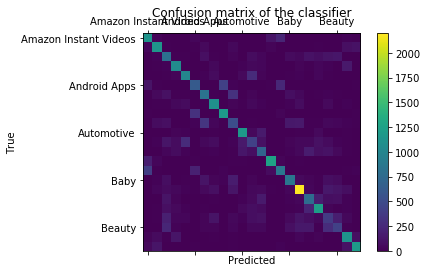

In [138]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

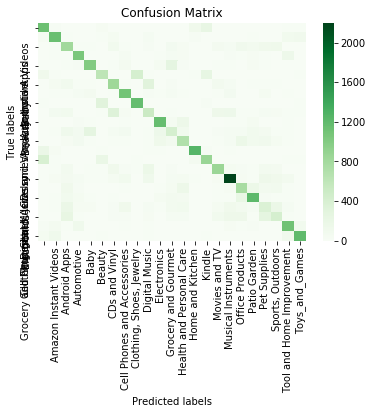

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([''] + get_all_labels());
ax.yaxis.set_ticklabels([''] + get_all_labels());

In [140]:
print(classification_report(all_labels, all_predictions,labels=labels, target_names=get_all_labels()))

                             precision    recall  f1-score   support

      Amazon Instant Videos       0.57      0.70      0.63      1615
               Android Apps       0.66      0.72      0.69      1611
                 Automotive       0.40      0.49      0.44      1672
                       Baby       0.63      0.69      0.66      1548
                     Beauty       0.65      0.63      0.64      1604
              CDs and Vinyl       0.47      0.42      0.44      1508
Cell Phones and Accessories       0.50      0.53      0.51      1572
   Clothing, Shoes, Jewelry       0.64      0.70      0.67      1579
              Digital Music       0.70      0.74      0.72      1604
                Electronics       0.36      0.33      0.34      1587
        Grocery and Gourmet       0.68      0.74      0.71      1585
   Health and Personal Care       0.30      0.26      0.28      1619
           Home and Kitchen       0.46      0.44      0.45      1627
                     Kindle      

# Finally here we try and implement the 1-Nearest classification process

In [57]:
# Load a pre-existing model 
PATH = '/content/5-model.pth'
model = TripletNetwork()
model.load_state_dict(torch.load(PATH))
model.cuda()

TripletNetwork(
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6)
    (8): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [0]:
# First of all, our model shall be the one we trained for embeddings in the 
# 60 dimensional space using Triplet loss. So,
embedding_model = model

In [0]:
from torch.utils.data import DataLoader
batch_size = 100
softmax_train_dataset = SoftmaxDataset(dataset=data_train,select_column='sentence_embedding')
softmax_test_dataset = SoftmaxDataset(dataset=data_test,select_column='sentence_embedding')
# Now the dataloaders need to be defined as well
classification_train_loader = DataLoader(softmax_train_dataset, batch_size=batch_size,shuffle=True)
classification_test_loader = DataLoader(softmax_test_dataset, batch_size=batch_size,shuffle=True)

In [0]:
# Let us save the embedding of all elements in the train_data as well as their index
# this can be used later for our purpose
embedding_space = []
for i, data in enumerate(classification_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        batch_size = inputs.shape[0]
        inputs = inputs.reshape(batch_size,-1)
        labels = labels.cuda()
        embeddings = embedding_model.fc(inputs)
        for index,tensor in enumerate(embeddings):
           embedding_space.append((labels[index],tensor))

In [36]:
dist = [space for index,space in embedding_space[:-1]]
result = torch.stack(dist, dim=0)
result.shape

torch.Size([155151, 64])

In [0]:
from collections import Counter
def k_nearest_neighbour(distance_embeddings, vector, k=3):   
    updated_result = torch.norm((distance_embeddings - vector),p=2,dim=1)
    values, indices = torch.topk(updated_result,k=k ,largest=False)
    candidate_indexes = []
    for index in indices:
      candidate_indexes.append((embedding_space[index][0]).item())
    return Counter(candidate_indexes).most_common(1)[0][0]

In [76]:
correct = 0
total = 0
all_labels = []
all_predictions=[]
for data in classification_test_loader:
    inputs, labels = data
    inputs = inputs.cuda()
    batch_size = inputs.shape[0]
    inputs = inputs.reshape(batch_size,-1)
    # Next the evaluation
    
    output = embedding_model.fc(inputs)
    for idx,query in enumerate(output):
        predicted = k_nearest_neighbour(result, query, 1)
        all_predictions.append(predicted)
        correct += (predicted == labels[idx])
        all_labels.append(labels[idx].item())
    total += labels.size(0)
    correct = correct.cpu().sum()
print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct /total))

Accuracy of the network on the test samples: 45 %


# Evaluating the Micro and Macro F1 scores

In [0]:
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report


In [40]:
f1_score(all_labels, all_predictions, average='micro') 

0.44565329483345373

In [41]:
f1_score(all_labels, all_predictions, average='macro') 

0.4401489228289628

In [0]:
labels = list(set(data_train.labels_encoded))
cm = confusion_matrix(all_labels, all_predictions, labels)

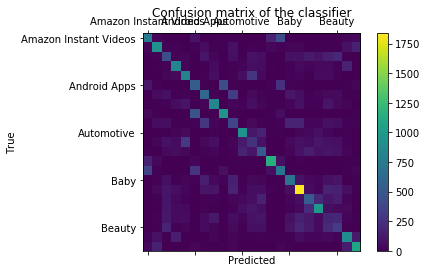

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + get_all_labels())
ax.set_yticklabels([''] + get_all_labels())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

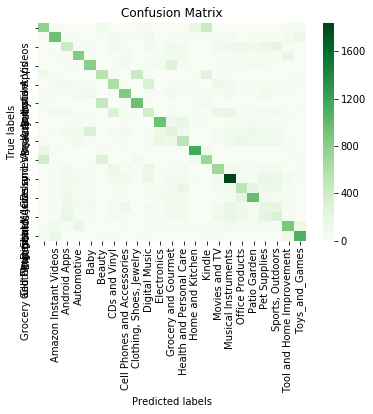

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([''] + get_all_labels());
ax.yaxis.set_ticklabels([''] + get_all_labels());

In [48]:
accuracy_score(all_labels, all_predictions)

0.4456532948334537

In [52]:
print(classification_report(all_labels, all_predictions,labels=labels, target_names=get_all_labels()))

                             precision    recall  f1-score   support

      Amazon Instant Videos       0.48      0.47      0.48      1615
               Android Apps       0.59      0.59      0.59      1611
                 Automotive       0.29      0.26      0.27      1672
                       Baby       0.53      0.54      0.53      1548
                     Beauty       0.50      0.51      0.50      1604
              CDs and Vinyl       0.34      0.36      0.35      1508
Cell Phones and Accessories       0.38      0.39      0.39      1572
   Clothing, Shoes, Jewelry       0.55      0.54      0.54      1579
              Digital Music       0.60      0.60      0.60      1604
                Electronics       0.24      0.24      0.24      1587
        Grocery and Gourmet       0.59      0.59      0.59      1585
   Health and Personal Care       0.17      0.17      0.17      1619
           Home and Kitchen       0.32      0.32      0.32      1627
                     Kindle      